<a href="https://colab.research.google.com/github/SahanaRaghu/Machine-Learning-cookbook/blob/master/AnalyticsVidyaLoanPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv


In [2]:
from google.colab import files
uploadedTest = files.upload()

Saving test.csv to test.csv


In [0]:
#Import to dataframe
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
import io
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

train_data = pd.read_csv(io.StringIO(uploaded['train.csv'].decode('utf-8')))
test_data = pd.read_csv(io.StringIO(uploadedTest['test.csv'].decode('utf-8')))

train_data = train_data.reindex(
    np.random.permutation(train_data.index))

In [0]:
#Make copies of orginal test & train data
train_data_original = train_data.copy
test_data_original = test_data.copy

In [7]:
train_data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
268,LP001883,Female,No,0,Graduate,NaN,3418,0.0,135.0,360.0,1.0,Rural,N
326,LP002068,Male,No,0,Graduate,No,4917,0.0,130.0,360.0,0.0,Rural,Y
293,LP001945,Female,No,NaN,Graduate,No,5417,0.0,143.0,480.0,0.0,Urban,N
220,LP001736,Male,Yes,0,Graduate,No,2221,0.0,60.0,360.0,0.0,Urban,N
408,LP002315,Male,Yes,1,Graduate,No,8300,0.0,152.0,300.0,0.0,Semiurban,N


In [15]:
train_data.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f69d39dbcf8>,
      dtype=object)

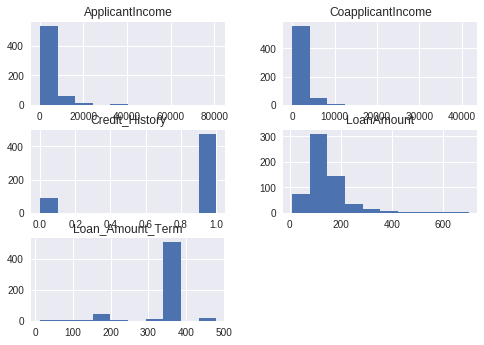

In [17]:
train_data.hist()